In [1]:
%matplotlib inline

import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import wfdb
import ast

In [2]:
import os

In [3]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(os.path.join(path,f)) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(os.path.join(path,f)) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [4]:
path='C:/TheCave/work-stuff/ECG/Datasets/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3'
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(os.path.join(path,'ptbxl_database.csv'), index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))


In [5]:
Y.scp_codes 

ecg_id
1                 {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}
2                             {'NORM': 80.0, 'SBRAD': 0.0}
3                               {'NORM': 100.0, 'SR': 0.0}
4                               {'NORM': 100.0, 'SR': 0.0}
5                               {'NORM': 100.0, 'SR': 0.0}
                               ...                        
21833    {'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...
21834             {'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}
21835                           {'ISCAS': 50.0, 'SR': 0.0}
21836                           {'NORM': 100.0, 'SR': 0.0}
21837                           {'NORM': 100.0, 'SR': 0.0}
Name: scp_codes, Length: 21799, dtype: object

In [6]:
Y.scp_codes.shape

(21799,)

In [7]:
X = load_raw_data(Y, sampling_rate, path)


In [8]:
agg_df = pd.read_csv(os.path.join(path,'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]


In [9]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [10]:
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [11]:
test_fold = 10

X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass

X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

In [12]:
X_train.shape

(19601, 1000, 12)

In [13]:
y_train.head

<bound method NDFrame.head of ecg_id
1        [NORM]
2        [NORM]
3        [NORM]
4        [NORM]
5        [NORM]
          ...  
21833    [STTC]
21834    [NORM]
21835    [STTC]
21836    [NORM]
21837    [NORM]
Name: diagnostic_superclass, Length: 19601, dtype: object>

In [14]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 19601 entries, 1 to 21837
Series name: diagnostic_superclass
Non-Null Count  Dtype 
--------------  ----- 
19601 non-null  object
dtypes: object(1)
memory usage: 306.3+ KB


In [15]:
np.unique(y_train).shape[0]


28

In [16]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_train_encoded = pd.DataFrame(mlb.fit_transform(y_train), columns=mlb.classes_)

In [17]:
y_train_encoded.shape

(19601, 5)

In [18]:
from sklearn.preprocessing import StandardScaler

In [19]:
standard_scaler=StandardScaler()
num_sample,time_stamps,lead_ecg=X_train.shape

In [20]:
X_train_new=X_train.reshape(num_sample,-1)
standard_scaler.fit_transform(X_train_new)

array([[-0.63699445, -0.25904753,  0.31693273, ...,  0.40698747,
        -0.14975585, -0.42330522],
       [ 0.02834186,  0.68852979,  0.65826793, ..., -0.91570464,
        -0.79910897, -0.50410628],
       [-0.150163  , -0.37688098, -0.23407982, ..., -0.00946991,
        -0.0934344 , -0.01606787],
       ...,
       [ 0.21225596,  0.12882091, -0.06341222, ..., -0.54323924,
        -0.38166768,  0.07119727],
       [-0.30162168, -0.26886698,  0.00485482, ...,  0.60641777,
         1.20527184, -0.06454851],
       [-0.25834777, -0.11175572,  0.12188404, ...,  0.29847393,
         0.1219123 , -0.3683605 ]])

In [21]:
# X_train=X_train_new.reshape(num_sample,time_stamps,lead_ecg)

In [22]:
from sklearn.decomposition import PCA
pca=PCA(n_components=3)
X_pca=pca.fit_transform(X_train_new)

In [23]:
X_pca

array([[ 0.16782382, -0.18961639,  0.05804079],
       [ 0.12314067, -0.88762323,  1.3128921 ],
       [ 0.33106334, -1.7557642 ,  0.30224978],
       ...,
       [ 0.09620096,  0.00651111, -0.06639984],
       [ 0.09021242, -0.15938162,  0.20229545],
       [ 0.00641119, -1.09571225,  0.47571206]])

In [24]:
X_pca.shape

(19601, 3)

In [25]:
y_train_encoded.shape

(19601, 5)

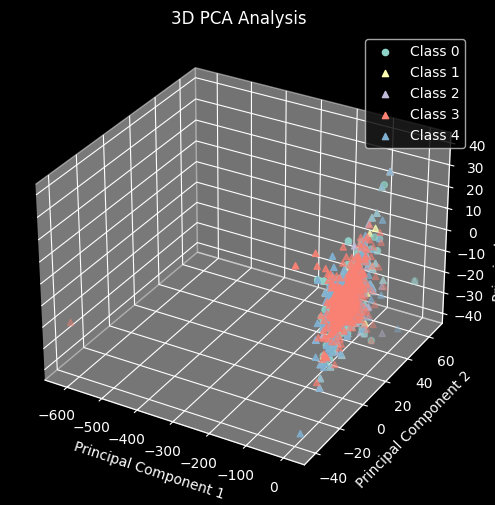

In [26]:

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

for class_label in range(y_train_encoded.shape[1]):
    indices = np.where(np.asarray(y_train_encoded)[:, class_label] == 1)
    marker = 'o' if class_label == 0 else '^'  # Use different markers for each class
    ax.scatter(X_pca[indices, 0], X_pca[indices, 1], X_pca[indices, 2], marker=marker, label=f'Class {class_label}')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA Analysis ')
ax.legend()

plt.show()

In [27]:
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained variance ratio for each component: {explained_variance_ratio}")
print(f"Total explained variance: {np.sum(explained_variance_ratio)}")


Explained variance ratio for each component: [0.03001559 0.01567525 0.01058881]
Total explained variance: 0.056279653088164586


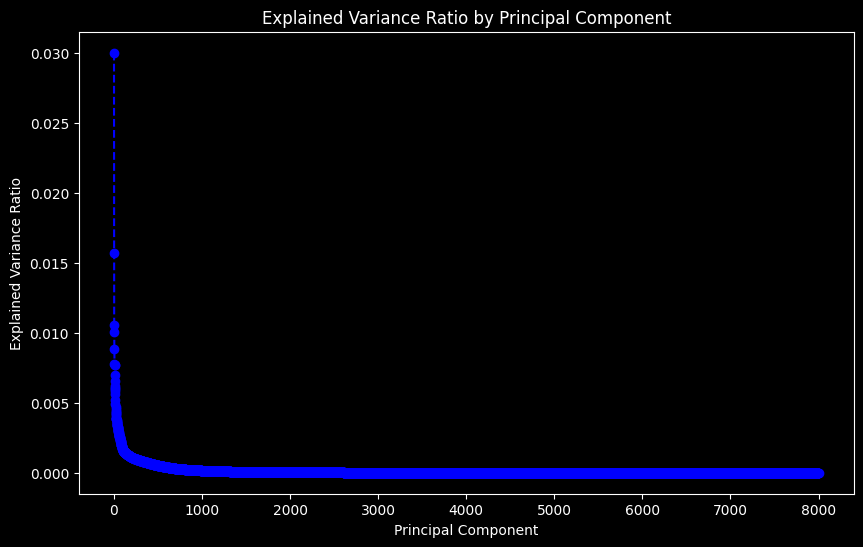

In [28]:
from sklearn.decomposition import IncrementalPCA


# Define batch size
batch_size = 8000  # Adjust this according to your memory constraints

# Initialize IncrementalPCA with a large number of components
n_components = 900  # Number of features as initial guess
ipca = IncrementalPCA()

# Fit IncrementalPCA on data in batches
for start in range(0, X_train_new.shape[0], batch_size):
    end = min(start + batch_size, X_train_new.shape[0])
    X_batch = X_train_new[start:end]
    ipca.partial_fit(X_batch)

# Explained variance ratio
explained_variance_ratio = ipca.explained_variance_ratio_
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--', color='b')
plt.title('Explained Variance Ratio by Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

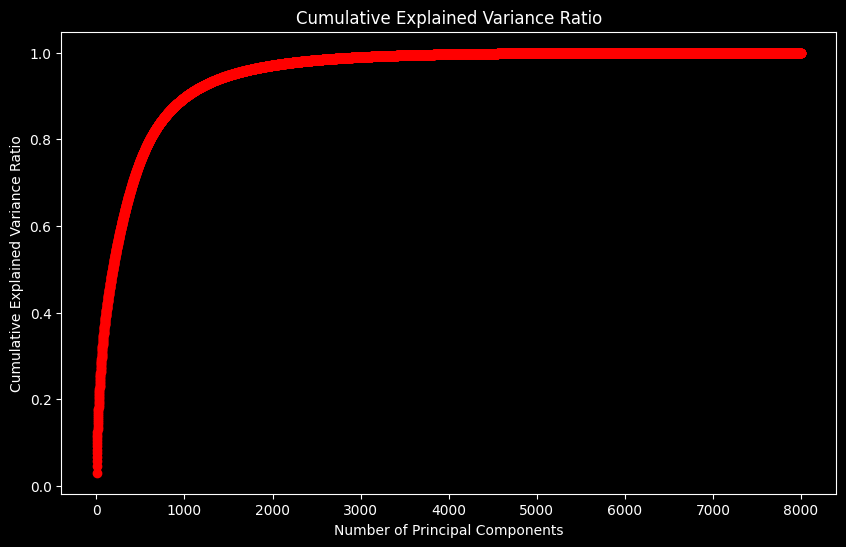

Number of components needed to explain 95.0% of variance: 1537


In [29]:
# Plot cumulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance_ratio) + 1), cumulative_explained_variance_ratio, marker='o', linestyle='--', color='r')
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()

# Determine the number of components needed to explain a certain variance threshold
variance_threshold = 0.95
n_components_needed = np.argmax(cumulative_explained_variance_ratio >= variance_threshold) + 1
print(f"Number of components needed to explain {variance_threshold*100}% of variance: {n_components_needed}")

In [31]:
def plot_ecg_samples(X, y, class_names, num_samples=3):
    fig, axes = plt.subplots(len(class_names), num_samples, figsize=(15, 10))
    for i, class_name in enumerate(class_names):
        class_indices = np.where(np.asarray(y)[:, i] == 1)[0]  # Find indices of the class
        for j in range(num_samples):
            idx = class_indices[j]  # Get the sample index
            ecg_signal = X[idx, :, 0]  # Plot the signal of the first channel
            axes[i, j].plot(ecg_signal)
            axes[i, j].set_title(f'{class_name} - Sample {j+1}')
            axes[i, j].set_xlabel('Time Steps')
            axes[i, j].set_ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

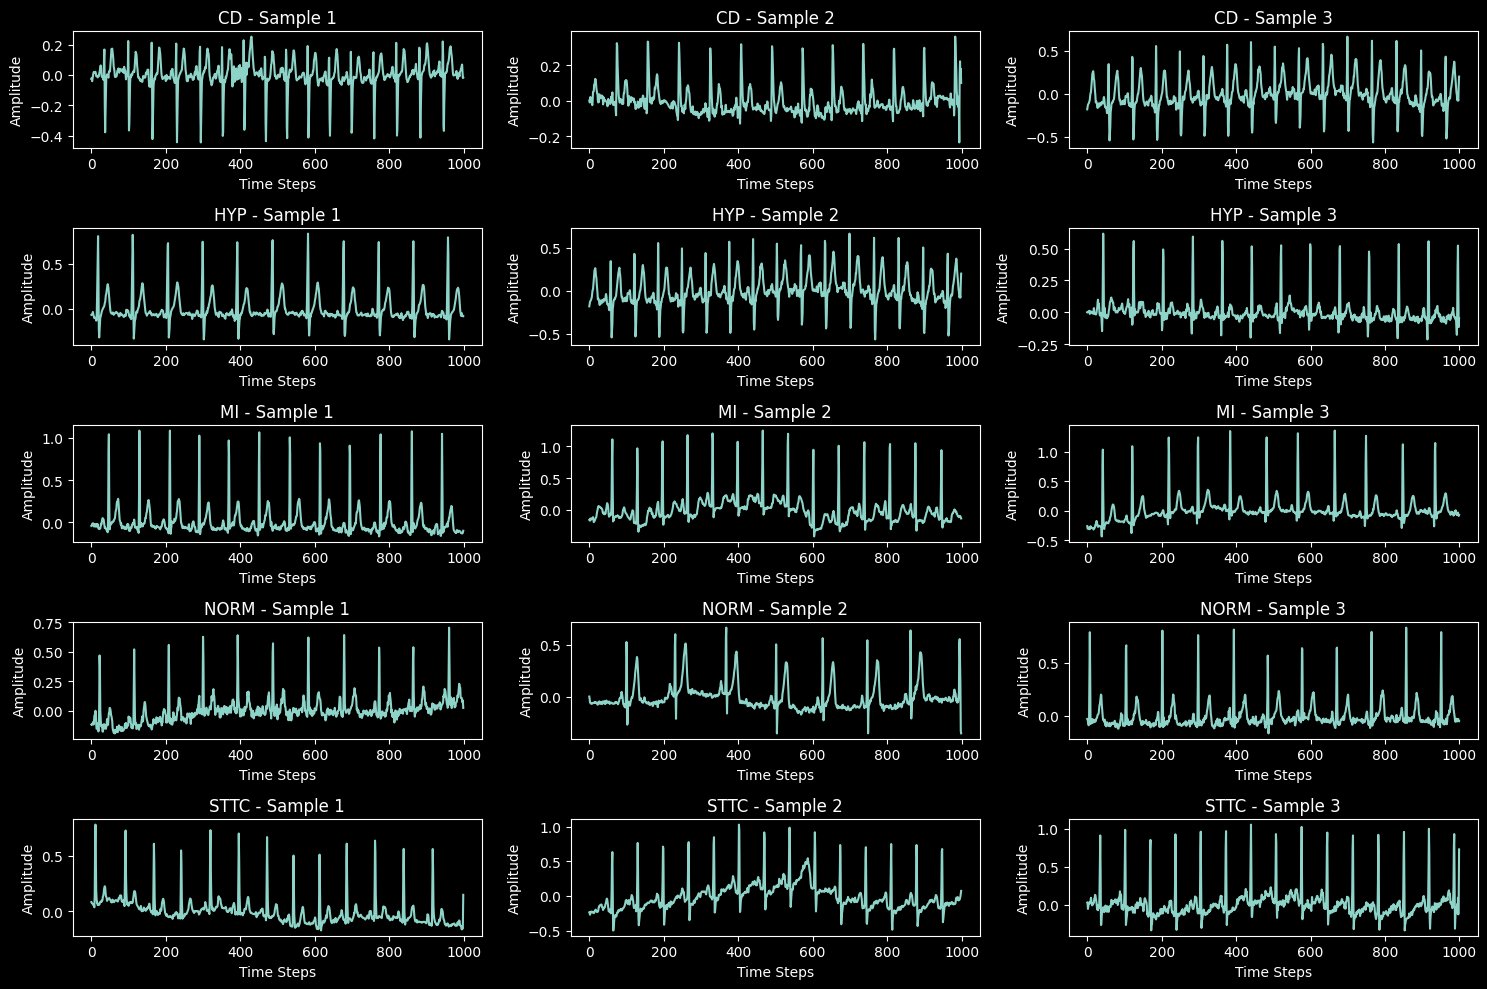

In [32]:
class_names = y_train_encoded.columns
plot_ecg_samples(X_train, y_train_encoded, class_names)

### Plotting all channels and classes for better visual understanding 

Classes : 

- Normal ECG: Healthy, normal heart activity.
- Conduction Disturbance: Problems with the electrical impulses that control heartbeats, including blocks and delays in conduction (e.g., bundle branch blocks).
- Hypertrophy: Enlargement of the heart muscles, typically due to high blood pressure or other cardiovascular conditions.
- Myocardial Infarction: ECG patterns indicative of a past or ongoing heart attack
- ST/T Changes: Abnormalities in the ST segment or T waves, often indicating ischemia, infarction, or other cardiac issues

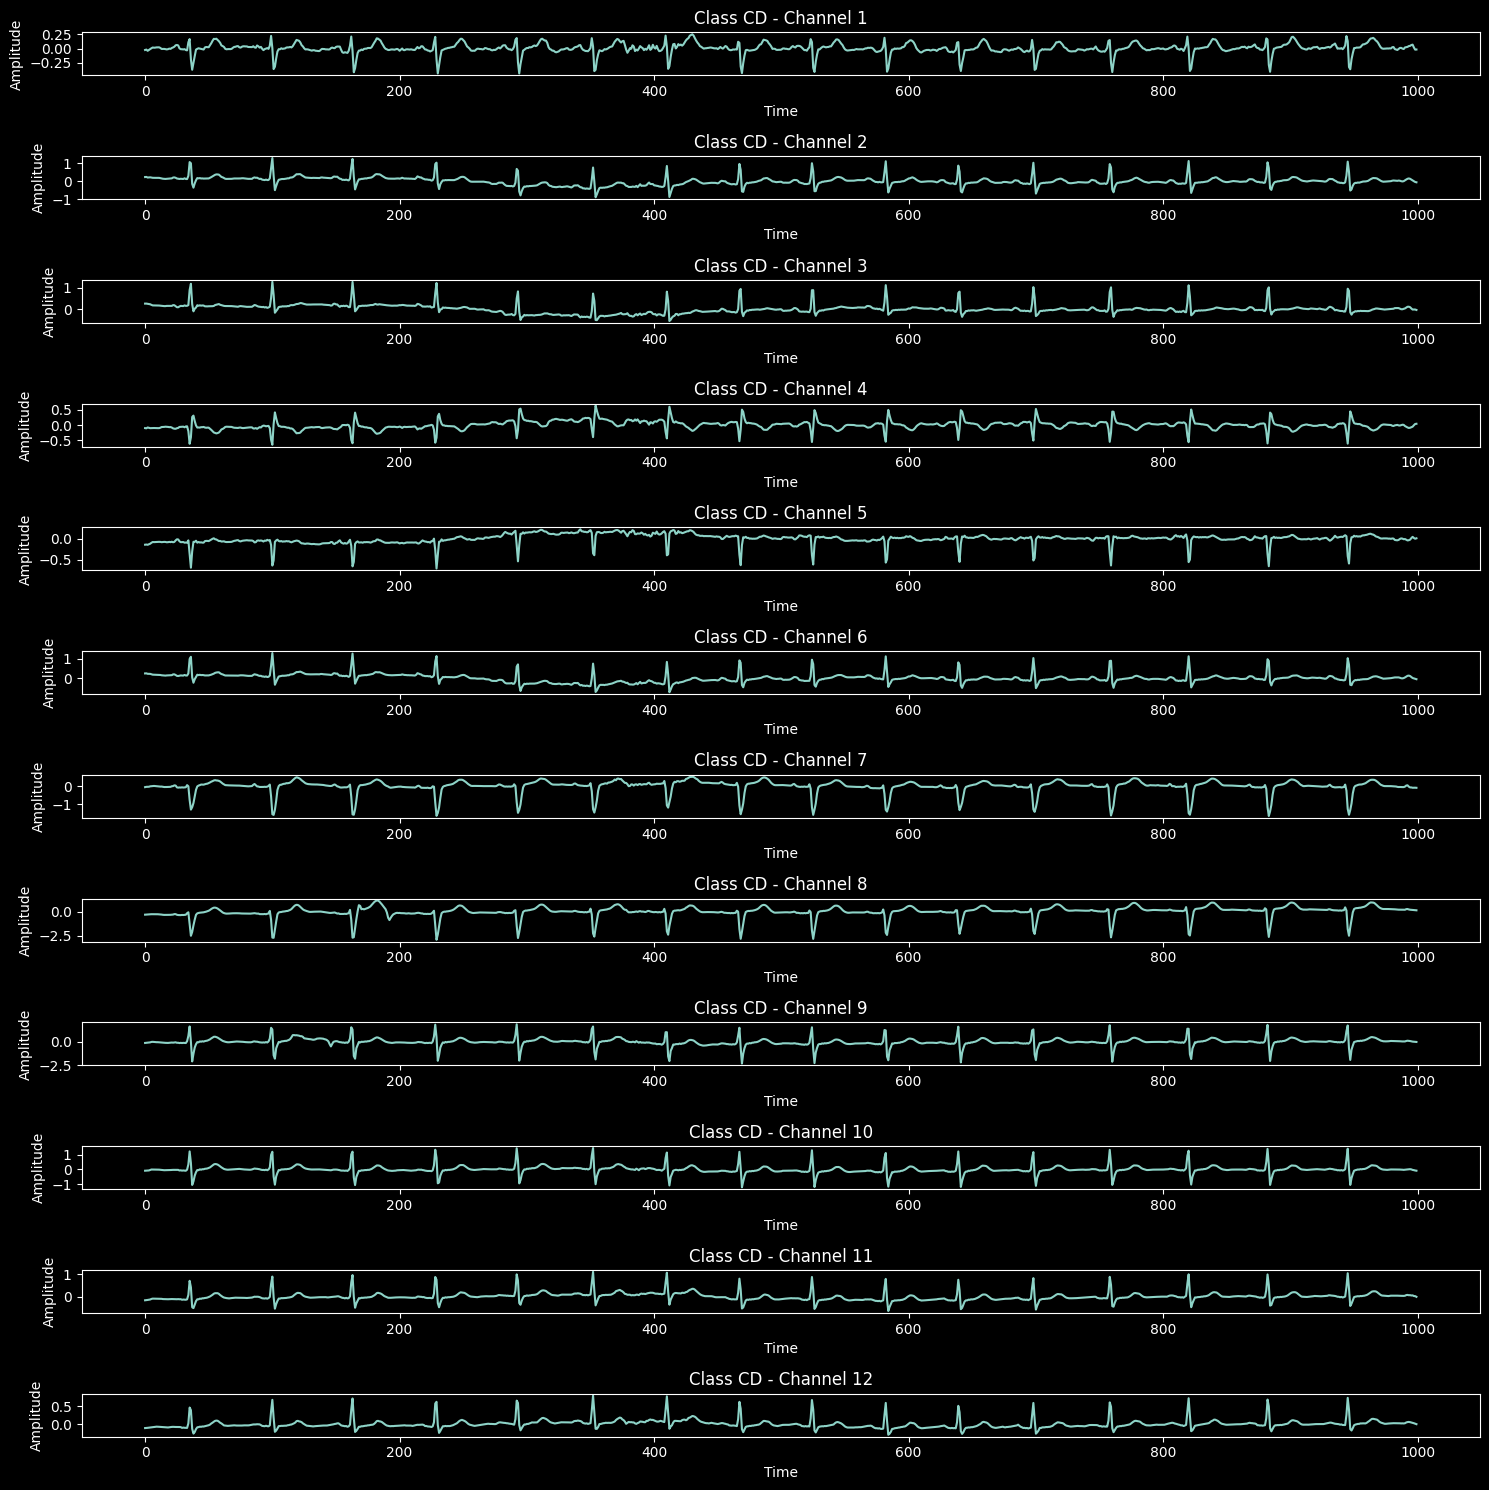

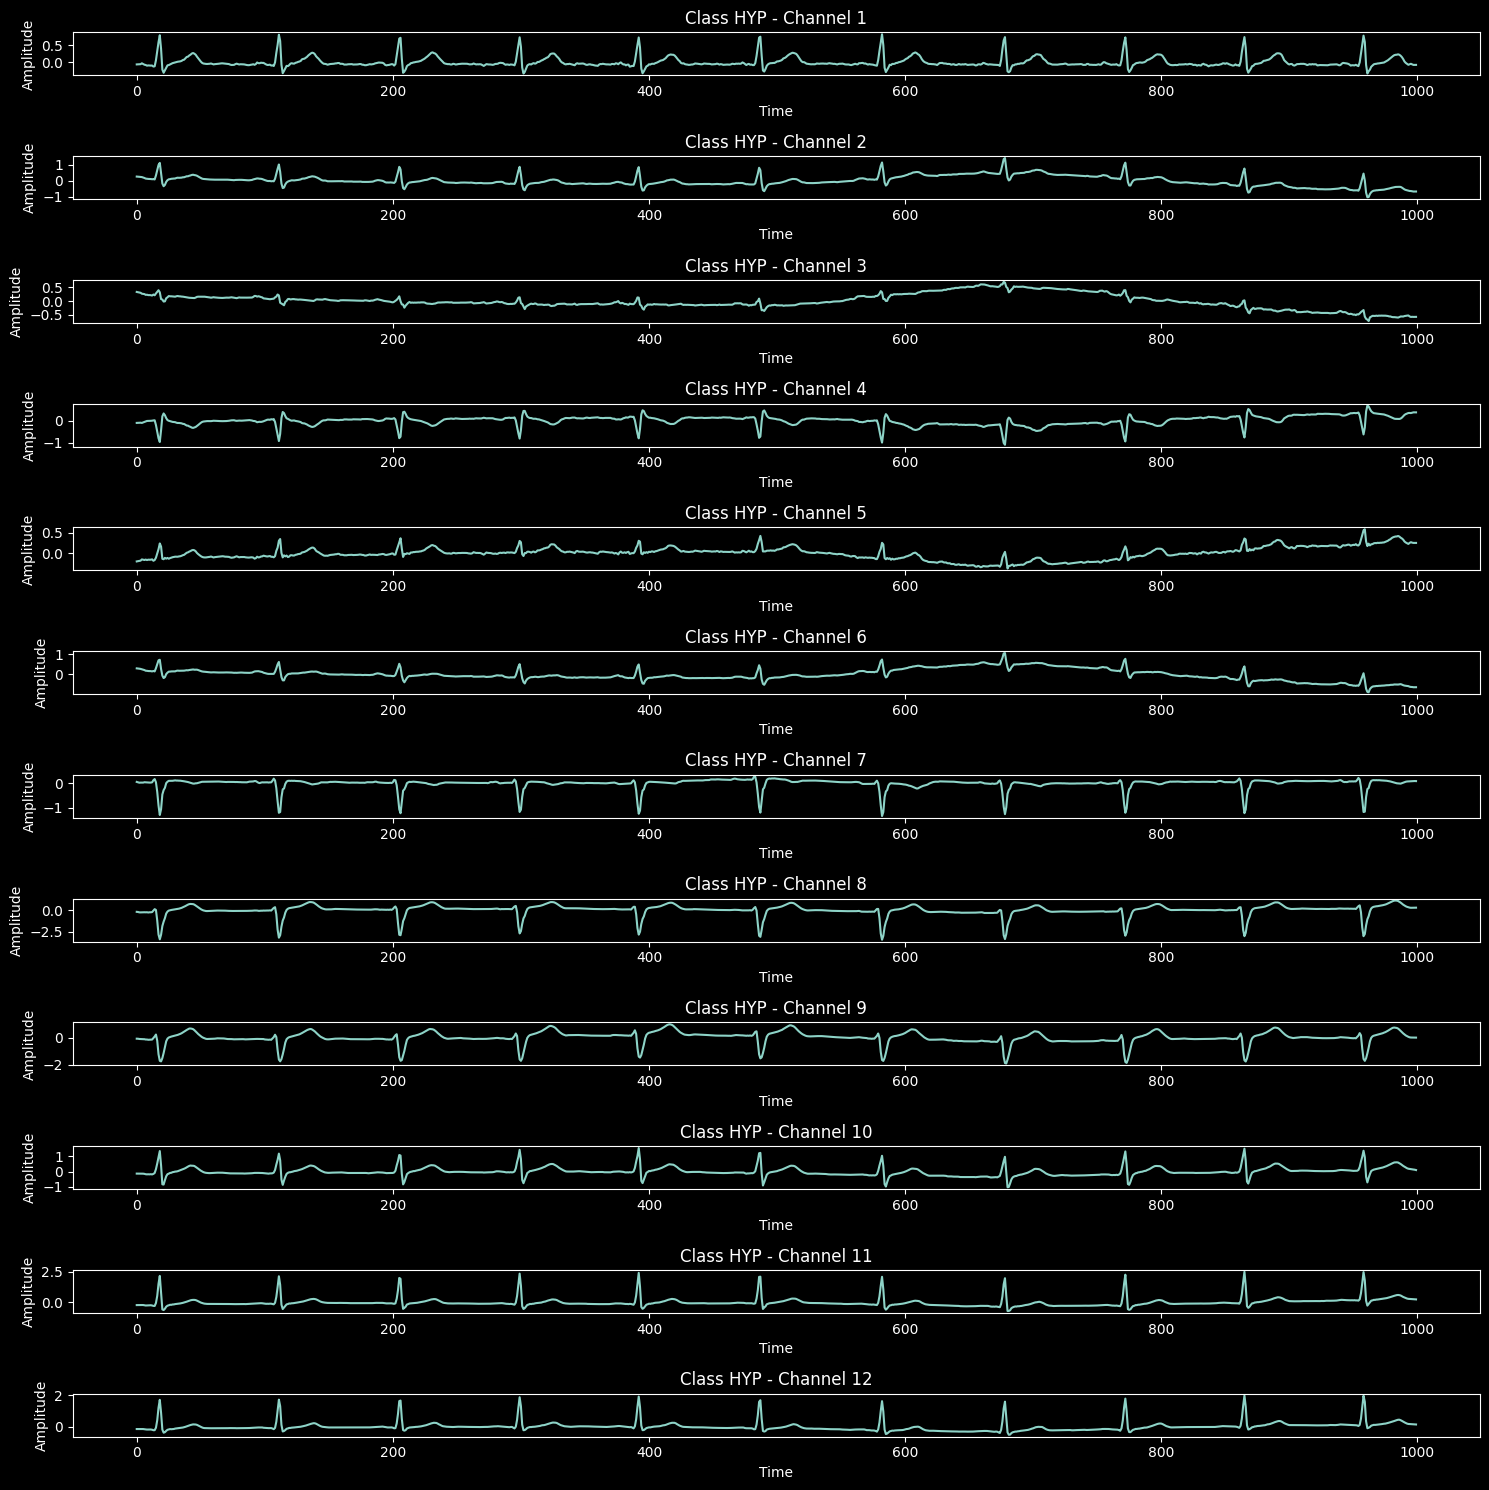

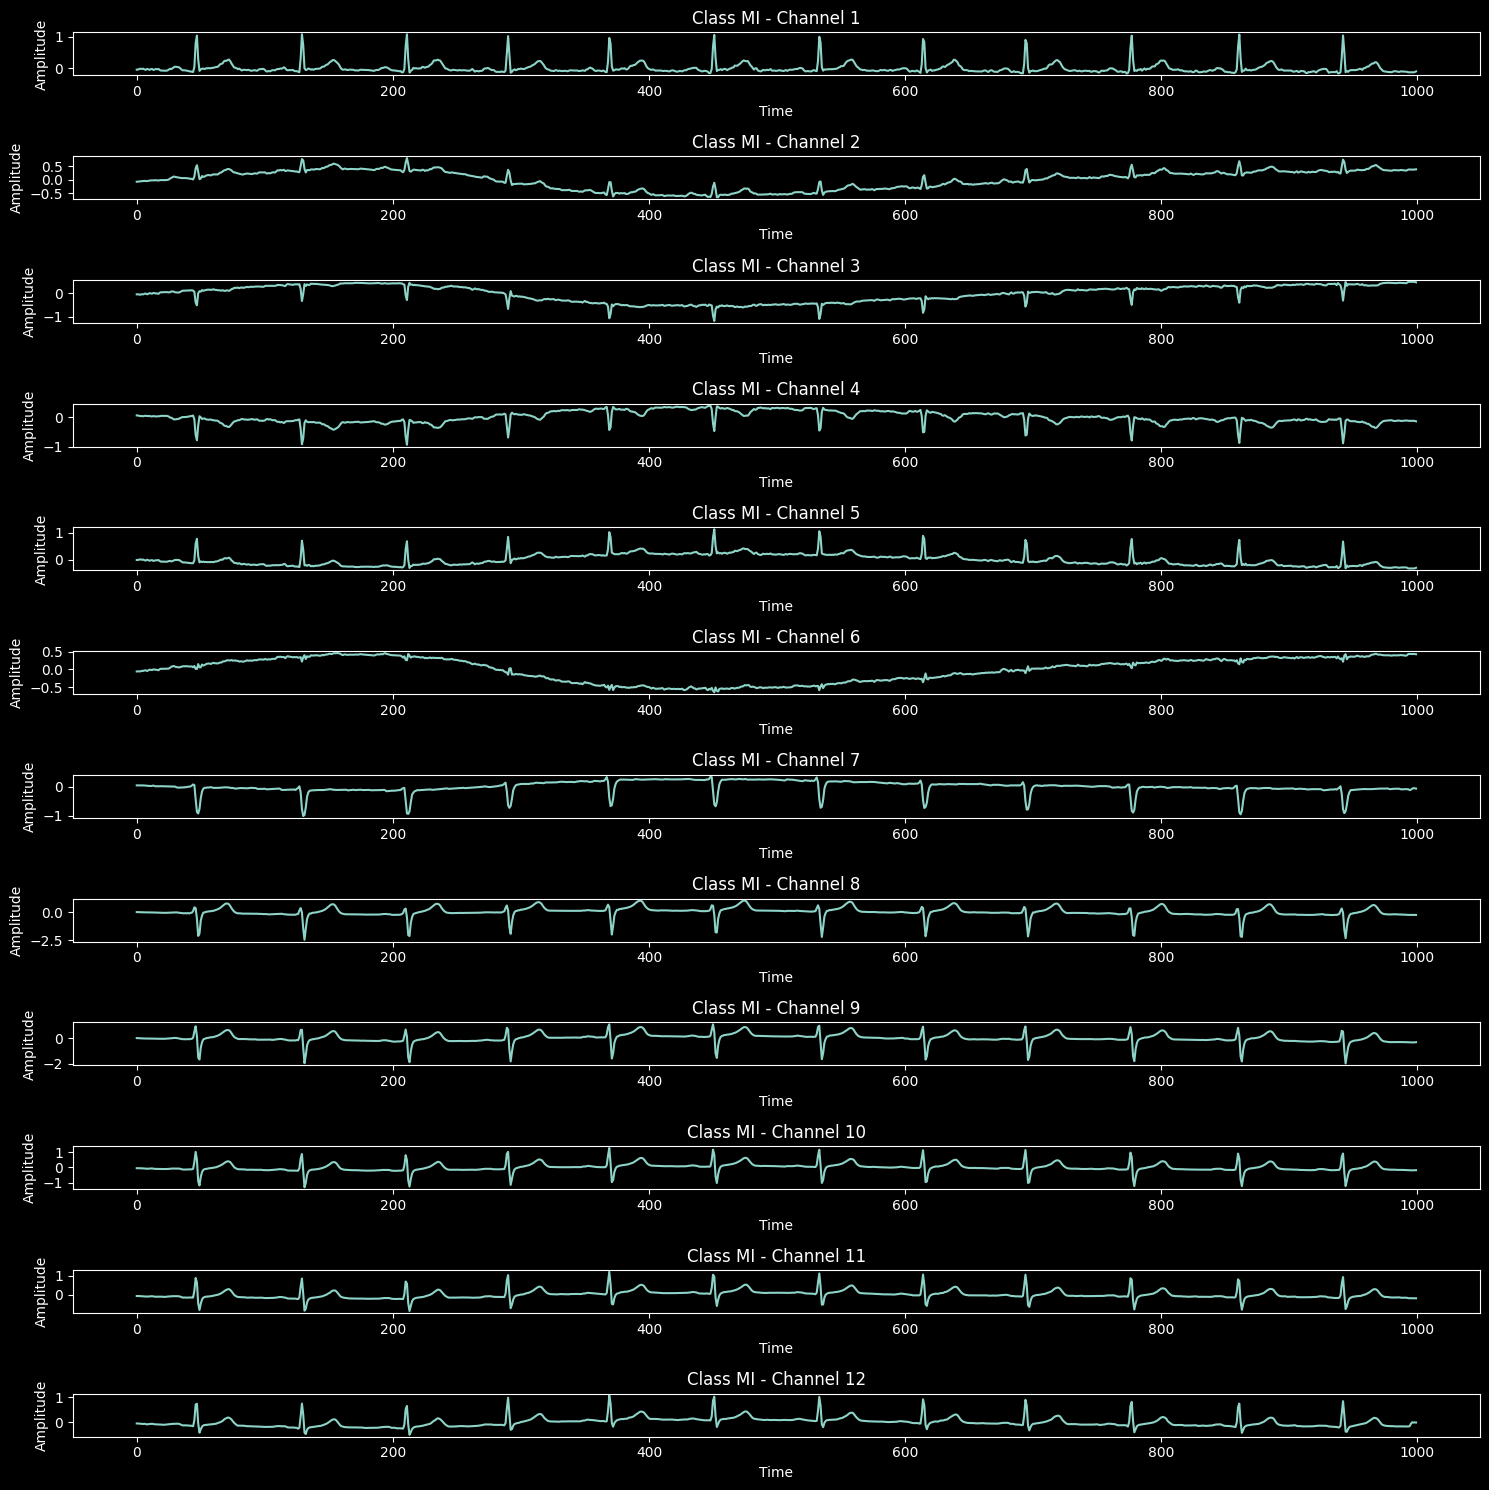

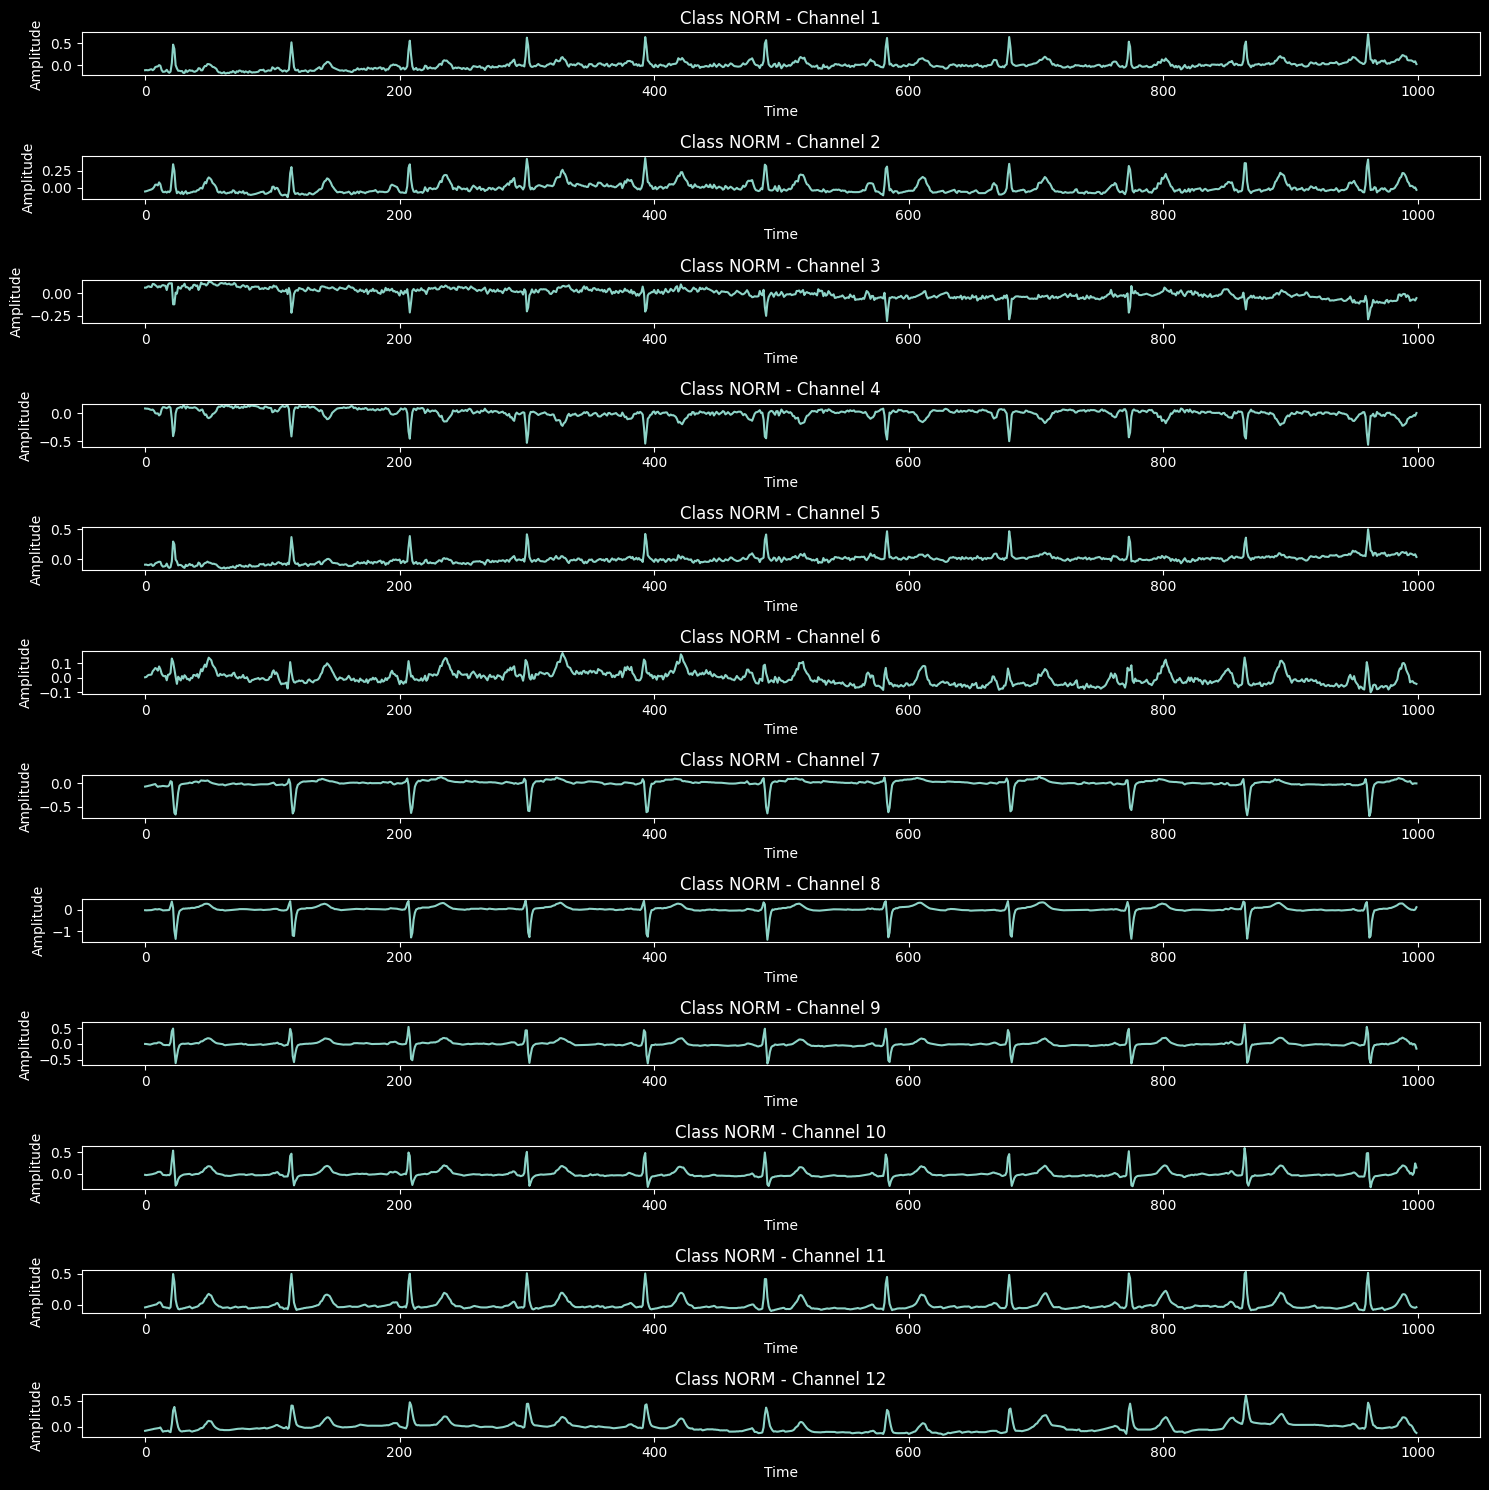

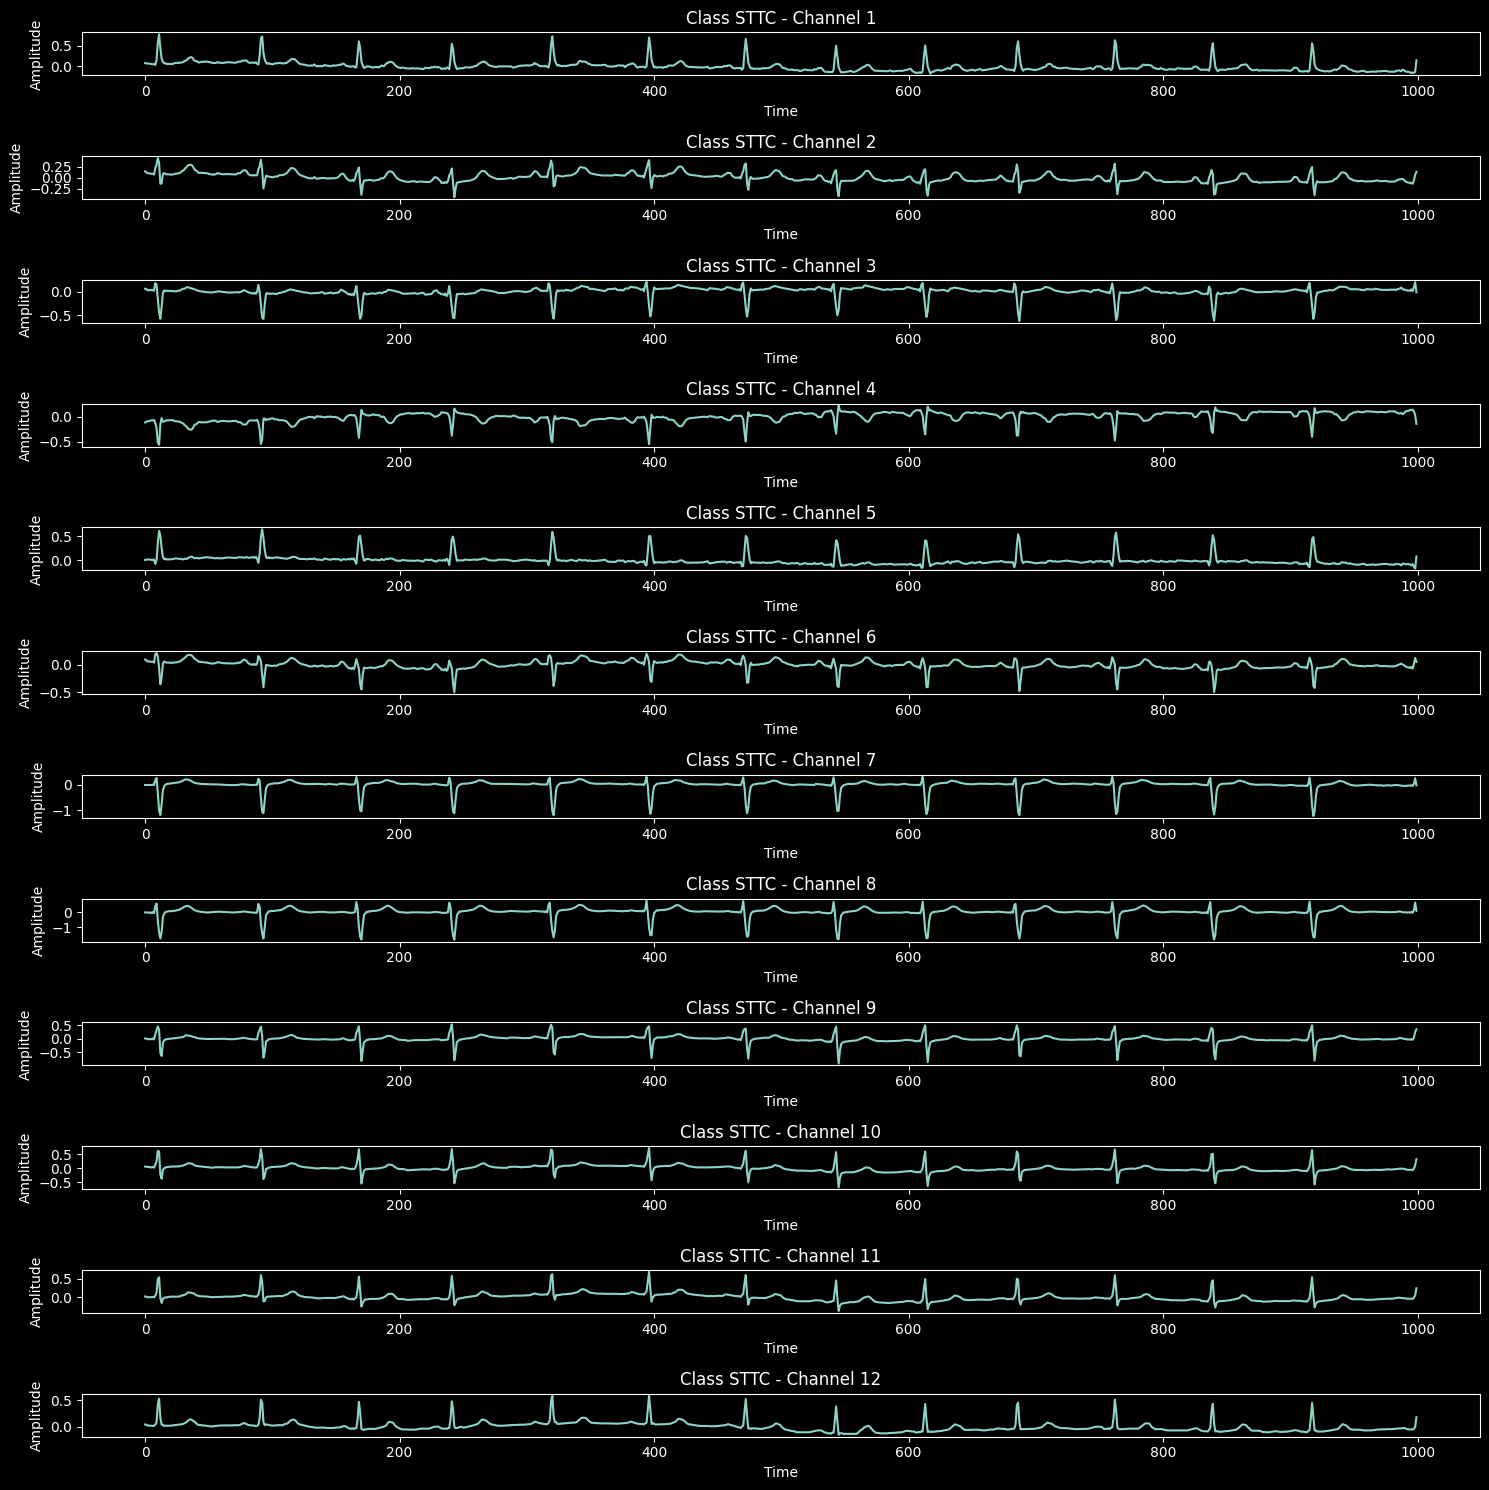

In [34]:
unique_classes = y_train_encoded.columns  # Getting the unique class labels
num_channels = X_train.shape[2]

# Loop through each class and plot the 12 channels for a representative sample
for class_label in unique_classes:
    # Get indices of the samples belonging to the current class
    class_indices = y_train_encoded.index[y_train_encoded[class_label] == 1]
    
    if len(class_indices) == 0:
        continue  # Skip classes without samples
    
    # Pick the first sample from the class for visualization
    sample_index = class_indices[0]
    
    # Plot the 12 channels for this class's sample
    plt.figure(figsize=(15, 15))
    for channel in range(num_channels):
        plt.subplot(num_channels, 1, channel + 1)
        plt.plot(X_train[sample_index, :, channel])
        plt.title(f"Class {class_label} - Channel {channel + 1}")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")

    plt.tight_layout()
    plt.show()

### Check variance in dataset across classes

In [46]:
num_classes = y_train_encoded.shape[1]  # Number of classes
num_channels = X_train.shape[2]  # Number of ECG channels 
time_steps = X_train.shape[1]  # Time steps in each ECG recording

# Initialize arrays to store mean and variance per class and per channel
class_means = np.zeros((num_classes, num_channels, time_steps))
class_vars = np.zeros((num_classes, num_channels, time_steps))

# Compute mean and variance for each class across all ECG channels
for class_label in range(num_classes):
    # Get the indices for the current class
    class_indices = np.where(y_train_encoded.iloc[:, class_label] == 1)[0]
    class_data = X_train[class_indices]  # ECG data for current class
    
    # Compute mean and variance for each channel
    class_means[class_label] = np.mean(class_data, axis=0)
    class_vars[class_label] = np.var(class_data, axis=0)

# Plot the results for each class (mean and variance for each channel)
for class_label in range(num_classes):
    plt.figure(figsize=(15, 10))
    
    # Plot mean ECG signals across all channels for the current class
    for channel in range(num_channels):
        plt.subplot(3, 4, channel + 1)
        plt.plot(class_means[class_label][channel], label=f'Channel {channel + 1}')
        plt.fill_between(range(time_steps), 
                         class_means[class_label][channel] - np.sqrt(class_vars[class_label][channel]),
                         class_means[class_label][channel] + np.sqrt(class_vars[class_label][channel]),
                         alpha=0.2)
        plt.title(f'Class {class_label} - Channel {channel + 1}')
        plt.xlabel('Time Steps')
        plt.ylabel('Amplitude')


ValueError: could not broadcast input array from shape (1000,12) into shape (5,1000)